# LSTM: Many-to-many setup

In [44]:
import re
import numpy as np
import unidecode
from keras.preprocessing.sequence import pad_sequences
from IPython import get_ipython;   
#get_ipython().magic('reset -sf')
import pandas
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout,Softmax,Flatten,concatenate
from keras.layers import LSTM
from keras.layers import *
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from IPython.display import Image

import pickle
import glob

In [55]:
# thetas = np.linspace(0,4*np.pi,1000)
# dataset = np.array([np.sin(thetas),np.sin(thetas)*np.cos(thetas)]).T
# dataset = dataset.astype('float32')
# plt.plot(dataset[:,0],dataset[:,1])
# plt.show()

pklfiles_to_process = glob.glob('./*.pkl')

print('Found %d pkl files: %s' % (len(pklfiles_to_process), pklfiles_to_process))

file_num = 1
with open(pklfiles_to_process[file_num], 'rb') as f:
    dataset_all = pickle.load(f)
    
# All the history trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
history_traj_data = np.array(dataset_all['features'])[:, :, :3]

# All the future trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
future_traj_data = np.array(dataset_all['labels'])[:, :, :2]

# All the goal positins and occupancy (x, y, occup), with shape (batch_size, (goal_nums * feature_dims))
goals_position = np.array(dataset_all['goals'])
goals_position = goals_position.reshape((goals_position.shape[0], goals_position.shape[1] * goals_position.shape[2]))

# All intention labels, with shape (batch_size, goal_nums)
goal_idx = np.array(dataset_all['labels'])[:, 0, -1]
# Convert to one-hot and the last one is undecided (-1)
one_hot_goal = to_categorical(goal_idx, num_classes=33)


Found 6 pkl files: ['./pilot_dataset_11_26_16_54_22.pkl', './pilot_dataset_11_26_16_54_22_fold_0.pkl', './pilot_dataset_11_26_16_54_22_fold_1.pkl', './pilot_dataset_11_26_16_54_22_fold_2.pkl', './pilot_dataset_11_26_16_54_22_fold_3.pkl', './pilot_dataset_11_26_16_54_22_fold_4.pkl']


In [56]:
# convert an array of values into a dataset matrix
# def create_dataset(dataset, look_back):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-look_back-look_back):
#         print
#         a = dataset[i:(i+look_back), :]
#         b = dataset[(i+look_back):(i+look_back+look_back),:]
#         dataX.append(a)
#         dataY.append(b)
#     return np.array(dataX), np.array(dataY)

In [57]:
# train_size = int(len(dataset)*0.67)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# # reshape into X=t and Y=t+1
# look_back = 20
# trainX, trainY = create_dataset(train, look_back)
# trainX.shape,trainY.shape

In [64]:
# Add your import statements here
from keras import Input, Model
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, Embedding
from keras.layers.recurrent import LSTM

def goal_model(traj_input_shape,goal_input_shape, hidden_dim,n_outputs):
    
    # Input to lstm
    lstm_input = Input(shape=(traj_input_shape),name="input_trajectory")
    
    # LSTM unit
    lstm = LSTM(hidden_dim,return_state=True,name="lstm_unit")
    
    # LSTM outputs
    lstm_outputs, state_h, state_c = lstm(lstm_input)
    
    # Input for goals
    goals_input = Input(shape=(goal_input_shape),name="goal_input")
    
    # Merge inputs with LSTM features
    concat_input = concatenate([goals_input,lstm_outputs],name="stacked_input")
    
    concat_output = Dense(100, activation="relu", name="concat_relu")(concat_input)
    
    # Final FC layer with a softmax activation
    goal_output = Dense(n_outputs,activation="softmax",name="goal_output")(concat_output)
        
    # Create final model
    model = Model([lstm_input,goals_input], goal_output)
    
    # Compile model using loss
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

def trajectory_model(traj_input_shape,goal_input_shape,hidden_dim,n_outputs):

    # Input to lstm
    lstm_input = Input(shape=(traj_input_shape),name="trajectory_input")
    
    # LSTM unit
    lstm = LSTM(hidden_dim,return_state=True,name="lstm_unit")
    
    # LSTM outputs
    lstm_outputs, state_h, state_c = lstm(lstm_input)
    encoder_states = [state_h,state_c]
    
    # Input for goals
    goals_input = Input(shape=(goal_input_shape),name="goal_input")
    
    # Repeat the goal inputs
    goals_repeated= RepeatVector(n_outputs)(goals_input)
    
    # Define decoder
    decoder = LSTM(hidden_dim,return_sequences=True, return_state=True)
    
    # Decoder outputs, initialize with previous lstm states
    decoder_outputs,_,_ = decoder(goals_repeated,initial_state=encoder_states)
    
    # Shape to a time series prediction of n_outputs x features
    decoder_fully_connected = TimeDistributed(Dense(n_outputs))(decoder_outputs)
    
    # Create final model
    model = Model([lstm_input,goals_input], decoder_fully_connected)
    
    # Compile model using loss
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model
    

In [66]:
print(history_traj_data.shape)
print(goals_position.shape)
print(one_hot_goal.shape)

traj_input_shape=(history_traj_data.shape[1], history_traj_data.shape[2])
goal_input_shape=(goals_position.shape[1],)
hidden_dim = 100
n_outputs = one_hot_goal.shape[1]
model = goal_model(traj_input_shape,goal_input_shape,hidden_dim,n_outputs)

model.fit([history_traj_data, goals_position], one_hot_goal, epochs=1000)
# traj_model = trajectory_model(traj_input_shape,goal_input_shape,hidden_dim,n_outputs)
# plot_model(model,to_file='model.png')
# plot_model(traj_model,to_file='traj_model.png')
# display(HTML("<table><tr><td><title>A</title><img src='model.png'></td><td><img src='traj_model.png'></td></tr></table>"))

(353, 5, 3)
(353, 96)
(353, 33)
Epoch 1/1000
353/353 [==============================] - 4s 11ms/step - loss: 9.1124
Epoch 2/1000
353/353 [==============================] - 0s 474us/step - loss: 5.1807
Epoch 3/1000
353/353 [==============================] - 0s 417us/step - loss: 4.4463
Epoch 4/1000
353/353 [==============================] - 0s 455us/step - loss: 3.9251
Epoch 5/1000
353/353 [==============================] - 0s 463us/step - loss: 3.4543
Epoch 6/1000
353/353 [==============================] - 0s 441us/step - loss: 3.3027
Epoch 7/1000
353/353 [==============================] - 0s 425us/step - loss: 3.2095
Epoch 8/1000
353/353 [==============================] - 0s 484us/step - loss: 3.2498
Epoch 9/1000
353/353 [==============================] - 0s 460us/step - loss: 3.1163
Epoch 10/1000
353/353 [==============================] - 0s 446us/step - loss: 3.0383
Epoch 11/1000
353/353 [==============================] - 0s 417us/step - loss: 3.3854
Epoch 12/1000
353/353 [=========

353/353 [==============================] - 0s 484us/step - loss: 1.9244
Epoch 97/1000
353/353 [==============================] - 0s 481us/step - loss: 2.0144
Epoch 98/1000
353/353 [==============================] - 0s 492us/step - loss: 1.9242
Epoch 99/1000
353/353 [==============================] - 0s 523us/step - loss: 1.8860
Epoch 100/1000
353/353 [==============================] - 0s 490us/step - loss: 1.9059
Epoch 101/1000
353/353 [==============================] - 0s 504us/step - loss: 1.8749
Epoch 102/1000
353/353 [==============================] - 0s 512us/step - loss: 1.8538
Epoch 103/1000
353/353 [==============================] - 0s 514us/step - loss: 1.8717
Epoch 104/1000
353/353 [==============================] - 0s 479us/step - loss: 1.8557
Epoch 105/1000
353/353 [==============================] - 0s 501us/step - loss: 1.8535
Epoch 106/1000
353/353 [==============================] - 0s 522us/step - loss: 1.8657
Epoch 107/1000
353/353 [==============================] - 0s 

353/353 [==============================] - 0s 456us/step - loss: 1.8767
Epoch 191/1000
353/353 [==============================] - 0s 492us/step - loss: 1.8128
Epoch 192/1000
353/353 [==============================] - 0s 487us/step - loss: 1.7461
Epoch 193/1000
353/353 [==============================] - 0s 489us/step - loss: 1.7616
Epoch 194/1000
353/353 [==============================] - 0s 484us/step - loss: 1.7293
Epoch 195/1000
353/353 [==============================] - 0s 491us/step - loss: 1.7525
Epoch 196/1000
353/353 [==============================] - 0s 489us/step - loss: 1.7152
Epoch 197/1000
353/353 [==============================] - 0s 494us/step - loss: 1.7032
Epoch 198/1000
353/353 [==============================] - 0s 476us/step - loss: 1.6938
Epoch 199/1000
353/353 [==============================] - 0s 502us/step - loss: 1.6985
Epoch 200/1000
353/353 [==============================] - 0s 506us/step - loss: 1.6856
Epoch 201/1000
353/353 [==============================] - 

353/353 [==============================] - 0s 463us/step - loss: 1.6268
Epoch 285/1000
353/353 [==============================] - 0s 538us/step - loss: 2.1147
Epoch 286/1000
353/353 [==============================] - 0s 474us/step - loss: 1.7781
Epoch 287/1000
353/353 [==============================] - 0s 508us/step - loss: 1.6863
Epoch 288/1000
353/353 [==============================] - 0s 506us/step - loss: 1.6481
Epoch 289/1000
353/353 [==============================] - 0s 506us/step - loss: 1.6464
Epoch 290/1000
353/353 [==============================] - 0s 530us/step - loss: 1.6458
Epoch 291/1000
353/353 [==============================] - 0s 502us/step - loss: 1.6467
Epoch 292/1000
353/353 [==============================] - 0s 515us/step - loss: 1.6316
Epoch 293/1000
353/353 [==============================] - 0s 560us/step - loss: 1.6300
Epoch 294/1000
353/353 [==============================] - 0s 503us/step - loss: 1.6180
Epoch 295/1000
353/353 [==============================] - 

353/353 [==============================] - 0s 469us/step - loss: 1.6005
Epoch 379/1000
353/353 [==============================] - 0s 543us/step - loss: 1.5967
Epoch 380/1000
353/353 [==============================] - 0s 527us/step - loss: 1.5960
Epoch 381/1000
353/353 [==============================] - 0s 467us/step - loss: 1.5935
Epoch 382/1000
353/353 [==============================] - 0s 487us/step - loss: 1.8880
Epoch 383/1000
353/353 [==============================] - 0s 498us/step - loss: 1.7598
Epoch 384/1000
353/353 [==============================] - 0s 507us/step - loss: 1.6390
Epoch 385/1000
353/353 [==============================] - 0s 530us/step - loss: 1.6217
Epoch 386/1000
353/353 [==============================] - 0s 538us/step - loss: 1.6291
Epoch 387/1000
353/353 [==============================] - 0s 496us/step - loss: 1.6067
Epoch 388/1000
353/353 [==============================] - 0s 488us/step - loss: 1.6000
Epoch 389/1000
353/353 [==============================] - 

353/353 [==============================] - 0s 496us/step - loss: 1.5814
Epoch 473/1000
353/353 [==============================] - 0s 526us/step - loss: 1.5788
Epoch 474/1000
353/353 [==============================] - 0s 527us/step - loss: 1.5784
Epoch 475/1000
353/353 [==============================] - 0s 501us/step - loss: 1.5847
Epoch 476/1000
353/353 [==============================] - 0s 558us/step - loss: 1.5794
Epoch 477/1000
353/353 [==============================] - 0s 488us/step - loss: 1.5826
Epoch 478/1000
353/353 [==============================] - 0s 513us/step - loss: 1.5857
Epoch 479/1000
353/353 [==============================] - 0s 548us/step - loss: 1.5807
Epoch 480/1000
353/353 [==============================] - 0s 516us/step - loss: 1.5745
Epoch 481/1000
353/353 [==============================] - 0s 547us/step - loss: 1.5799
Epoch 482/1000
353/353 [==============================] - 0s 499us/step - loss: 1.5787
Epoch 483/1000
353/353 [==============================] - 

353/353 [==============================] - 0s 499us/step - loss: 0.2975
Epoch 567/1000
353/353 [==============================] - 0s 534us/step - loss: 0.2761
Epoch 568/1000
353/353 [==============================] - 0s 522us/step - loss: 0.2757
Epoch 569/1000
353/353 [==============================] - 0s 516us/step - loss: 0.2669
Epoch 570/1000
353/353 [==============================] - 0s 596us/step - loss: 0.2636
Epoch 571/1000
353/353 [==============================] - 0s 483us/step - loss: 0.2924
Epoch 572/1000
353/353 [==============================] - 0s 499us/step - loss: 0.2801
Epoch 573/1000
353/353 [==============================] - 0s 540us/step - loss: 0.2767
Epoch 574/1000
353/353 [==============================] - 0s 507us/step - loss: 0.2651
Epoch 575/1000
353/353 [==============================] - 0s 517us/step - loss: 0.2876
Epoch 576/1000
353/353 [==============================] - 0s 508us/step - loss: 0.2726
Epoch 577/1000
353/353 [==============================] - 

353/353 [==============================] - 0s 478us/step - loss: 0.2430
Epoch 661/1000
353/353 [==============================] - 0s 490us/step - loss: 0.2452
Epoch 662/1000
353/353 [==============================] - 0s 525us/step - loss: 0.2544
Epoch 663/1000
353/353 [==============================] - 0s 517us/step - loss: 0.2438
Epoch 664/1000
353/353 [==============================] - 0s 511us/step - loss: 0.2497
Epoch 665/1000
353/353 [==============================] - 0s 513us/step - loss: 0.2429
Epoch 666/1000
353/353 [==============================] - 0s 507us/step - loss: 0.2496
Epoch 667/1000
353/353 [==============================] - 0s 536us/step - loss: 0.2446
Epoch 668/1000
353/353 [==============================] - 0s 524us/step - loss: 0.2462
Epoch 669/1000
353/353 [==============================] - 0s 527us/step - loss: 0.2429
Epoch 670/1000
353/353 [==============================] - 0s 522us/step - loss: 0.2436
Epoch 671/1000
353/353 [==============================] - 

353/353 [==============================] - 0s 501us/step - loss: 0.2418
Epoch 755/1000
353/353 [==============================] - 0s 520us/step - loss: 0.2424
Epoch 756/1000
353/353 [==============================] - 0s 530us/step - loss: 0.2420
Epoch 757/1000
353/353 [==============================] - 0s 498us/step - loss: 0.2406
Epoch 758/1000
353/353 [==============================] - 0s 547us/step - loss: 0.2415
Epoch 759/1000
353/353 [==============================] - 0s 511us/step - loss: 0.2428
Epoch 760/1000
353/353 [==============================] - 0s 481us/step - loss: 0.2420
Epoch 761/1000
353/353 [==============================] - 0s 496us/step - loss: 0.2419
Epoch 762/1000
353/353 [==============================] - 0s 515us/step - loss: 0.2393
Epoch 763/1000
353/353 [==============================] - 0s 537us/step - loss: 0.2396
Epoch 764/1000
353/353 [==============================] - 0s 532us/step - loss: 0.2400
Epoch 765/1000
353/353 [==============================] - 

353/353 [==============================] - 0s 472us/step - loss: 0.6925
Epoch 849/1000
353/353 [==============================] - 0s 528us/step - loss: 0.4457
Epoch 850/1000
353/353 [==============================] - 0s 504us/step - loss: 0.3373
Epoch 851/1000
353/353 [==============================] - 0s 517us/step - loss: 0.2918
Epoch 852/1000
353/353 [==============================] - 0s 525us/step - loss: 0.2605
Epoch 853/1000
353/353 [==============================] - 0s 536us/step - loss: 0.2589
Epoch 854/1000
353/353 [==============================] - 0s 525us/step - loss: 0.2515
Epoch 855/1000
353/353 [==============================] - 0s 517us/step - loss: 0.2498
Epoch 856/1000
353/353 [==============================] - 0s 512us/step - loss: 0.2528
Epoch 857/1000
353/353 [==============================] - 0s 468us/step - loss: 0.2508
Epoch 858/1000
353/353 [==============================] - 0s 493us/step - loss: 0.2440
Epoch 859/1000
353/353 [==============================] - 

353/353 [==============================] - 0s 470us/step - loss: 0.2349
Epoch 943/1000
353/353 [==============================] - 0s 493us/step - loss: 0.2368
Epoch 944/1000
353/353 [==============================] - 0s 512us/step - loss: 0.2359
Epoch 945/1000
353/353 [==============================] - 0s 543us/step - loss: 0.2369
Epoch 946/1000
353/353 [==============================] - 0s 530us/step - loss: 0.2359
Epoch 947/1000
353/353 [==============================] - 0s 539us/step - loss: 0.2368
Epoch 948/1000
353/353 [==============================] - 0s 598us/step - loss: 0.2356
Epoch 949/1000
353/353 [==============================] - 0s 427us/step - loss: 0.2354
Epoch 950/1000
353/353 [==============================] - 0s 527us/step - loss: 0.2352
Epoch 951/1000
353/353 [==============================] - 0s 550us/step - loss: 0.2371
Epoch 952/1000
353/353 [==============================] - 0s 517us/step - loss: 0.2355
Epoch 953/1000
353/353 [==============================] - 

In [50]:
# Add your import statements here
from keras import Input, Model
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, Embedding
from keras.layers.recurrent import LSTM

def create_encoder(X_seq_len,X_seq_feat,Y_seq_len,Y_seq_feat, hidden_dim):
    # Set up input shape to encoder
    encoder_input_layer = Input(shape=(X_seq_len,X_seq_feat))
    
    # Define encoder
    encoder = LSTM(hidden_dim,return_state=True)
    # Encoder outputs - but only consider the memory and weights
    encoder_outputs, state_h, state_c = encoder(encoder_input_layer)
    
    goal_input_layer = Input(shape=(32,))
    
    
    encoder_input = concatenate([state_h,state_c,goal_input_layer])
    
    FC = Dense(33,activation='softmax')(encoder_input)
        
    # Create final model
    model = Model([encoder_input_layer,goal_input_layer], FC)
    
    # Compile model using loss
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model
    

In [51]:
# Add your import statements here
from keras import Input, Model
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, Embedding
from keras.layers.recurrent import LSTM

def create_decoder(X_seq_len,X_seq_feat,Y_seq_len,Y_seq_feat, hidden_dim):
    
    
    decoder_input = Input(shape=(53,))
    decoder_fc = Dense((2*hidden_dim))(decoder_input)
    decoder_shape = Reshape((2,hidden_dim))(decoder_fc)
    
    
    
    
    
    
    # We need to feed the decoder some zero inputs that is uncorrelated
    null_input = Input(shape=[Y_seq_feat])
    repeated_null = RepeatVector(Y_seq_len)(null_input)
    
    # Define decoder
    decoder = LSTM(hidden_dim,return_sequences=True, return_state=True)
    decoder_outputs,_,_ = decoder(repeated_null,initial_state=[decoder_shape[0],decoder_shape[1]])
    decoder_fully_connected = TimeDistributed(Dense(Y_seq_feat))(decoder_outputs)
        
    # Create final model
    model = Model([decoder_input,null_input], decoder_fully_connected)
    
    # Compile model using loss
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model
    

In [103]:
input_len = 20
input_feat = 2
output_len = 20
output_feat = 2
hidden_dim = 20
model = create_model(input_len,input_feat,output_len,output_feat,hidden_dim)
#print(model.summary())
encoder = create_encoder(input_len,input_feat,output_len,output_feat,hidden_dim)
decoder = create_decoder(input_len,input_feat,output_len,output_feat,hidden_dim)
#print(encoder.summary())
print(decoder.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_132 (InputLayer)       (None, 2)                 0         
_________________________________________________________________
repeat_vector_26 (RepeatVect (None, 20, 2)             0         
_________________________________________________________________
lstm_86 (LSTM)               [(None, 20, 20), (None, 2 1840      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 20, 2)             42        
Total params: 1,882
Trainable params: 1,882
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
input_len = 20
input_feat = 2
output_len = 20
output_feat = 2
hidden_dim = 20
model = create_model(input_len,input_feat,
                     output_len,output_feat,hidden_dim)
print(model.summary())
x = trainX[:,:,:]
y = trainY[:,:,:]
z = np.zeros((len(x),output_feat))
#model.fit([x,z],y,epochs=100)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 20, 2)        0                                            
__________________________________________________________________________________________________
repeat_vector_6 (RepeatVector)  (None, 20, 2)        0           input_34[0][0]                   
__________________________________________________________________________________________________
lstm_26 (LSTM)                  [(None, 20), (None,  1840        input_33[0][0]                   
__________________________________________________________________________________________________
lstm_27 (L

In [8]:
xp = model.predict([x,z])

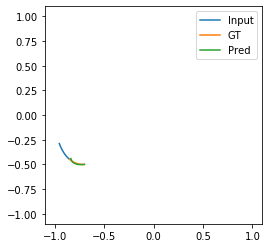

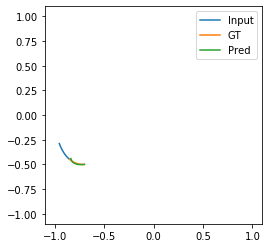

In [9]:
line, = plt.plot([],[],label='Input')
line1, = plt.plot([],[],label='GT')
line2, = plt.plot([],[],label='Pred')
plt.legend()
ax = plt.gca()
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_aspect('equal')
for i in range(400):
    line.set_data(trainX[i,:,0],trainX[i,:,1])
    line1.set_data(trainY[i,:,0],trainY[i,:,1])
    line2.set_data(xp[i,:,0],xp[i,:,1])
    display.clear_output(wait=True)
    display.display(plt.gcf()) 